# AFM Digital Twin: Basic functionality

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/DTMicroscope/blob/main/notebooks/AFM/0_AFM_Basic_functionality_COLAB_Hackaton.ipynb)


This notebook provides introductory examples for accessing and utilizing the **AFM Digital Twin**. These examples will guide you through the initial steps of opening the digital twin  configuring basic settings, and simulating AFM operations.

# 1. Run server

In [1]:
!pip install pyro5
!pip install scifireaders
!pip install sidpy
!pip install pynsid
!pip install git+https://github.com/pycroscopy/DTMicroscope.git


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/pycroscopy/DTMicroscope.git to c:\users\aisci\appdata\local\temp\pip-req-build-s0h8w5yt
  Resolved https://github.com/pycroscopy/DTMicroscope.git to commit 23f925cbaa141d958795736266a9246effd53532
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/DTMicroscope.git 'C:\Users\aisci\AppData\Local\Temp\pip-req-build-s0h8w5yt'

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!run_server_afm

Server started and running in the background. Logs are being written to server.log.


# 2. Client side

In [3]:
import matplotlib.pylab as plt
import numpy as np
import Pyro5.api
from IPython.display import clear_output, display

## 2.1 Get data

In [4]:
!wget https://github.com/pycroscopy/DTMicroscope/raw/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5

--2025-12-16 10:21:15--  https://github.com/pycroscopy/DTMicroscope/raw/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pycroscopy/DTMicroscope/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5 [following]
--2025-12-16 10:21:15--  https://raw.githubusercontent.com/pycroscopy/DTMicroscope/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22317256 (21M) [application/octet-stream]
Saving to: 'dset_spm1.h5'

     0K .......... .......... .......... .......... ..........  0% 1.86M 11s
    50K .......... 

## 2.2 Register Data to the Digital twin

In [6]:
from pathlib import Path
import importlib.resources as resources
import sys

uri = "PYRO:microscope.server@localhost:9092"  # port for the AFM DT 9092
mic_server = Pyro5.api.Proxy(uri)

def _locate_data_file(filename: str) -> Path:
    candidates = []
    try:
        candidates.append(resources.files("DTMicroscope.test.datasets") / filename)
    except Exception:
        pass

    search_roots = [Path.cwd()] + list(Path.cwd().parents)
    for root in search_roots:
        candidates.extend([
            root / filename,
            root / "notebooks" / "AFM" / filename,
            root / "test" / "datasets" / filename,
            root / "DTMicroscope" / "test" / "datasets" / filename,
        ])

    for candidate in candidates:
        if candidate.exists():
            return candidate
    raise FileNotFoundError(f"Could not find {filename}. Place it next to the notebook or in DTMicroscope/test/datasets.")

if 'google.colab' in sys.modules:
    data_path = Path("dset_spm1.h5")
else:
    data_path = _locate_data_file("dset_spm1.h5")

mic_server.initialize_microscope("AFM", data_path=str(data_path))
mic_server.setup_microscope(data_source='Compound_Dataset_1')  # upload dataset
mic_server.get_dataset_info()


CommunicationError: cannot connect to ('localhost', 9092): [WinError 10061] No connection could be made because the target machine actively refused it

# 3. Basic AFM operations

## 3.1 .get_scan()

The `get_scan()` function retrieves scan data from the dataset, with the option to filter by specific channels. Use the `channels` attribute to specify desired channels, allowing you to query particular signals or data channels. For details on available channels, refer to `.get_dataset_info()`.

The `direction` parameter specifies the fast-scanning axis, while the `trace` parameter emulates data acquisition on either the forward or backward pass. These settings are essential for accurately simulating the behavior of the real PID during scanning.

The `modification` parameter allows the application of various imperfections to simulate realistic scanning conditions, such as the effects of a broken tip or non-ideal PID performance.

In [6]:
#scan without modification
array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace', 'Phase1Retrace'],
                                                 modification=None,
                                                 direction = 'horizontal',
                                                 trace = 'forward')
dat =  np.array(array_list, dtype=dtype).reshape(shape)
dat.shape

(2, 256, 256)

Text(0.5, 1.0, 'Phase1Retrace')

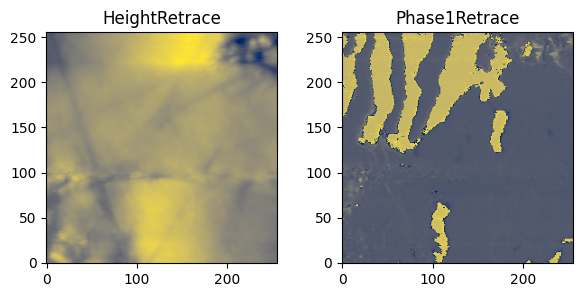

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].imshow(dat[0].T, cmap='cividis', origin='lower')
ax[0].set_title('HeightRetrace')
ax[1].imshow(dat[1].T, cmap='cividis', origin='lower')
ax[1].set_title('Phase1Retrace')

## 3.2 .scanning_emulator()

Generates a simulation of the scanning process, acquiring data in real-time line by line.

- The `scan_rate` parameter controls the speed of the simulated scan.
- Other parameters are consistent with those used in the `.get_scan()` method.


Line 255


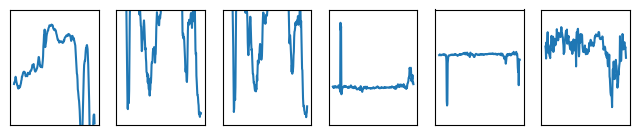

StopIteration: 

In [19]:
gen = mic_server.scanning_emulator(scanning_rate=10)
k = 0

print(f'Line {k}')
line = next(gen)
line = [np.array(l) for l in line]  # Convert list back to numpy array
fig, ax = plt.subplots(1, len(line), figsize=(8,1.5))
for i, ax_ in enumerate(ax):
    ax_.plot(np.arange(len(line[i])), line[i])
    ax_.set_xticks([])
    ax_.set_yticks([])
plt.ion()  # Enable interactive mode
plt.show()
k += 1

while True:
    line = next(gen)
    line = [np.array(l) for l in line]  # Convert list back to numpy array
    for i, ax_ in enumerate(ax):
        ax_.lines[0].set_data(np.arange(len(line[i])), line[i])

    clear_output(wait=True)
    print(f'Line {k}')
    display(fig)

    k += 1

## 3.3 .scan_individual_line()

Get an individual line either 'vertical' or 'horizontal' requested by the **real** coordinate.

The `coord` parameter specifies the scan coordinate: the x-coordinate if `direction='vertical'` and the y-coordinate if `direction='horizontal'`.


In [20]:
array_list, shape, dtype  = mic_server.scan_individual_line('vertical', coord = -1e-6, channels=['Amplitude1Retrace', 'Phase1Retrace'])
line = np.array(array_list, dtype=dtype).reshape(shape)

Text(0.5, 1.0, 'Phase1Retrace')

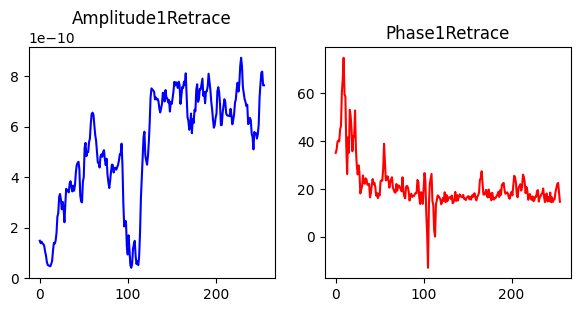

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].plot(line[0].T, color='b')
ax[0].set_title('Amplitude1Retrace')
ax[1].plot(line[1].T, color='r')
ax[1].set_title('Phase1Retrace')

## 3.4 .scan_arbitrary_path()

This method returns the response data for the specified channels, captured along the trajectory defined by the coordinate array.


In [22]:
corners = np.array([[-2e-6,2e-6],[1e-6,1.8e-6],[2.1e-6,2e-6]]) #real coordinates
array_list, shape, dtype  = mic_server.get_scan(channels=['Amplitude1Retrace',])
dat = np.array(array_list, dtype=dtype).reshape(shape)

Text(0.5, 1.0, 'Trajectory')

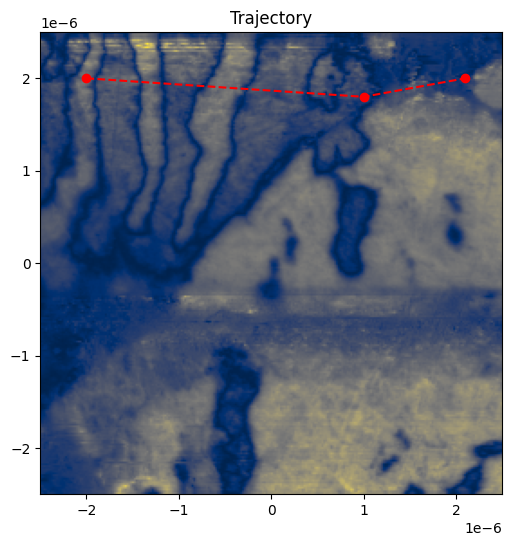

In [23]:
fig = plt.figure(figsize=(6,6))
plt.imshow(dat[0].T, origin='lower', extent=(mic_server.x_min, mic_server.x_max, mic_server.y_min, mic_server.y_max), cmap='cividis')
plt.scatter(corners[:,0], corners[:,1], color='red')
plt.plot(*corners.T, '--', color='red')
plt.title('Trajectory')

Text(0, 0.5, 'Response')

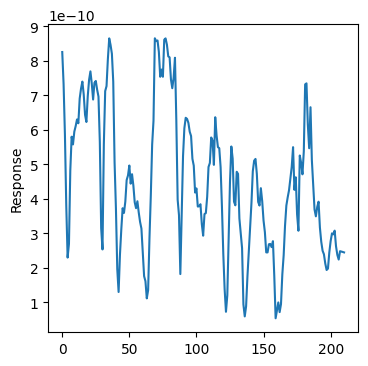

In [24]:
array_list, shape, dtype  = mic_server.scan_arbitrary_path(path_points = corners.tolist(), channels=['Amplitude1Retrace'])
line = np.array(array_list, dtype=dtype).reshape(shape)

fig = plt.figure(figsize=(4,4))
plt.plot(line[0])
plt.ylabel('Response')

## 3.5 .get_spectrum()

If spectral data is available in the dataset, the `get_spectrum` method allows retrieval of the requested spectrum at the current probe position to simulate spectroscopic measurements.

The current probe position can be accessed via the `.x` and `.y` class variables and changed by `.go_to()` method.

In [25]:
#print current probe position
print(f'Current location: {mic_server.x, mic_server.y}')

Current location: (-1e-06, -2.5e-06)


In [26]:
(array_list_spec, shape_spec, dtype_spec), (array_list_y, shape_y, dtype_y) = mic_server.get_spectrum()
_spec_dim = np.array(array_list_spec, dtype=dtype_spec).reshape(shape_spec)
_y = np.array(array_list_y, dtype=dtype_y).reshape(shape_y)
res = (_spec_dim, _y)

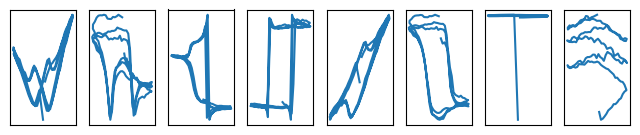

In [27]:
fig, ax = plt.subplots(1, len(res[1]), figsize=(8, 1.5))
for i in range(len(res[1])):
    ax[i].plot(res[0], res[1][i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

Change the measurement point and repeat the measurement.

In [28]:
mic_server.go_to(x=1e-6, y=1e-6)
print(f'Current location: {mic_server.x, mic_server.y}')

(array_list_spec, shape_spec, dtype_spec), (array_list_y, shape_y, dtype_y) = mic_server.get_spectrum()
_spec_dim = np.array(array_list_spec, dtype=dtype_spec).reshape(shape_spec)
_y = np.array(array_list_y, dtype=dtype_y).reshape(shape_y)
res = (_spec_dim, _y)

Current location: (1e-06, 1e-06)


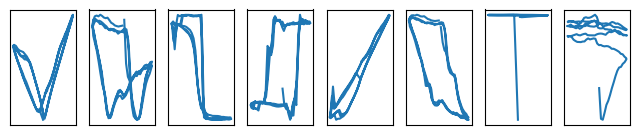

In [29]:
fig, ax = plt.subplots(1, len(res[1]), figsize=(8, 1.5))
for i in range(len(res[1])):
    ax[i].plot(res[0], res[1][i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])